In [ ]:
import matplotlib.pyplot as plt
import torch
import numpy as np
import cv2
%load_ext autoreload
%autoreload 2
from SCUNET import SCUNet as net
import math

import os

from PIL import Image
from IPython.display import display

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# methods

In [16]:
def uint2single(img):

    return np.float32(img/255.)

def single2uint(img):

    return np.uint8((img.clip(0, 1)*255.).round())

def single2tensor(img):
    
    return torch.from_numpy(np.ascontiguousarray(img)).permute(2, 0, 1).float().unsqueeze(0)

# convert 2/3/4-dimensional torch tensor to uint
def tensor2uint(img):
    img = img.data.squeeze().float().clamp_(0, 1).cpu().numpy()
    if img.ndim == 3:
        img = np.transpose(img, (1, 2, 0))
    return np.uint8((img*255.0).round())

# --------------------------------------------
# PSNR
# --------------------------------------------
def calculate_psnr(img1, img2, border=0):
    # img1 and img2 have range [0, 255]
    #img1 = img1.squeeze()
    #img2 = img2.squeeze()
    if not img1.shape == img2.shape:
        raise ValueError('Input images must have the same dimensions.')
    h, w = img1.shape[:2]
    img1 = img1[border:h-border, border:w-border]
    img2 = img2[border:h-border, border:w-border]

    img1 = img1.astype(np.float64)
    img2 = img2.astype(np.float64)
    mse = np.mean((img1 - img2)**2)
    if mse == 0:
        return float('inf')
    return 20 * math.log10(255.0 / math.sqrt(mse))


# --------------------------------------------
# SSIM
# --------------------------------------------
def calculate_ssim(img1, img2, border=0):
    '''calculate SSIM
    the same outputs as MATLAB's
    img1, img2: [0, 255]
    '''
    #img1 = img1.squeeze()
    #img2 = img2.squeeze()
    if not img1.shape == img2.shape:
        raise ValueError('Input images must have the same dimensions.')
    h, w = img1.shape[:2]
    img1 = img1[border:h-border, border:w-border]
    img2 = img2[border:h-border, border:w-border]

    if img1.ndim == 2:
        return ssim(img1, img2)
    elif img1.ndim == 3:
        if img1.shape[2] == 3:
            ssims = []
            for i in range(3):
                ssims.append(ssim(img1[:,:,i], img2[:,:,i]))
            return np.array(ssims).mean()
        elif img1.shape[2] == 1:
            return ssim(np.squeeze(img1), np.squeeze(img2))
    else:
        raise ValueError('Wrong input image dimensions.')
    
def ssim(img1, img2):
    C1 = (0.01 * 255)**2
    C2 = (0.03 * 255)**2

    img1 = img1.astype(np.float64)
    img2 = img2.astype(np.float64)
    kernel = cv2.getGaussianKernel(11, 1.5)
    window = np.outer(kernel, kernel.transpose())

    mu1 = cv2.filter2D(img1, -1, window)[5:-5, 5:-5]  # valid
    mu2 = cv2.filter2D(img2, -1, window)[5:-5, 5:-5]
    mu1_sq = mu1**2
    mu2_sq = mu2**2
    mu1_mu2 = mu1 * mu2
    sigma1_sq = cv2.filter2D(img1**2, -1, window)[5:-5, 5:-5] - mu1_sq
    sigma2_sq = cv2.filter2D(img2**2, -1, window)[5:-5, 5:-5] - mu2_sq
    sigma12 = cv2.filter2D(img1 * img2, -1, window)[5:-5, 5:-5] - mu1_mu2

    ssim_map = ((2 * mu1_mu2 + C1) * (2 * sigma12 + C2)) / ((mu1_sq + mu2_sq + C1) *
                                                            (sigma1_sq + sigma2_sq + C2))
    return ssim_map.mean()

def evaluate(img_H, img_E):
    img_H = img_H.squeeze()

    # --------------------------------
    # PSNR and SSIM
    # --------------------------------
    psnr = calculate_psnr(img_E, img_H, border=0)
    ssim = calculate_ssim(img_E, img_H, border=0)
    return psnr, ssim

def test_onesplit(model, L, refield=32, min_size=256, sf=1, modulo=1):
    '''
    model:
    L: input Low-quality image
    refield: effective receptive filed of the network, 32 is enough
    min_size: min_sizeXmin_size image, e.g., 256X256 image
    sf: scale factor for super-resolution, otherwise 1
    modulo: 1 if split
    '''
    h, w = L.size()[-2:]

    top = slice(0, (h//2//refield+1)*refield)
    bottom = slice(h - (h//2//refield+1)*refield, h)
    left = slice(0, (w//2//refield+1)*refield)
    right = slice(w - (w//2//refield+1)*refield, w)
    Ls = [L[..., top, left], L[..., top, right], L[..., bottom, left], L[..., bottom, right]]
    Es = [model(Ls[i]) for i in range(4)]
    b, c = Es[0].size()[:2]
    E = torch.zeros(b, c, sf * h, sf * w).type_as(L)
    E[..., :h//2*sf, :w//2*sf] = Es[0][..., :h//2*sf, :w//2*sf]
    E[..., :h//2*sf, w//2*sf:w*sf] = Es[1][..., :h//2*sf, (-w + w//2)*sf:]
    E[..., h//2*sf:h*sf, :w//2*sf] = Es[2][..., (-h + h//2)*sf:, :w//2*sf]
    E[..., h//2*sf:h*sf, w//2*sf:w*sf] = Es[3][..., (-h + h//2)*sf:, (-w + w//2)*sf:]
    return E

# variables

In [17]:
model_zoo = 'model_zoo'
need_degradation = True
noise_level_img = 50
model_name = f'scunet_gray_{noise_level_img}'
model_path = os.path.join(model_zoo, model_name+'.pth')
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [18]:
model = net(in_nc=1,config=[4,4,4,4,4,4,4],dim=64)
model.load_state_dict(torch.load(model_path), strict=True)
model.to(device)
model.eval()

Block Initial Type: W, drop_path_rate:0.000000
Block Initial Type: SW, drop_path_rate:0.000000
Block Initial Type: W, drop_path_rate:0.000000
Block Initial Type: SW, drop_path_rate:0.000000
Block Initial Type: W, drop_path_rate:0.000000
Block Initial Type: SW, drop_path_rate:0.000000
Block Initial Type: W, drop_path_rate:0.000000
Block Initial Type: SW, drop_path_rate:0.000000
Block Initial Type: W, drop_path_rate:0.000000
Block Initial Type: SW, drop_path_rate:0.000000
Block Initial Type: W, drop_path_rate:0.000000
Block Initial Type: SW, drop_path_rate:0.000000
Block Initial Type: W, drop_path_rate:0.000000
Block Initial Type: SW, drop_path_rate:0.000000
Block Initial Type: W, drop_path_rate:0.000000
Block Initial Type: SW, drop_path_rate:0.000000
Block Initial Type: W, drop_path_rate:0.000000
Block Initial Type: SW, drop_path_rate:0.000000
Block Initial Type: W, drop_path_rate:0.000000
Block Initial Type: SW, drop_path_rate:0.000000
Block Initial Type: W, drop_path_rate:0.000000
Blo

C:\Users\3aboo\AppData\Local\Temp\ipykernel_23200\3212692792.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_path), strict=True)


SCUNet(
  (m_head): Sequential(
    (0): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  )
  (m_down1): Sequential(
    (0): ConvTransBlock(
      (trans_block): Block(
        (ln1): LayerNorm((32,), eps=1e-05, elementwise_affine=True)
        (msa): WMSA(
          (embedding_layer): Linear(in_features=32, out_features=96, bias=True)
          (linear): Linear(in_features=32, out_features=32, bias=True)
        )
        (drop_path): Identity()
        (ln2): LayerNorm((32,), eps=1e-05, elementwise_affine=True)
        (mlp): Sequential(
          (0): Linear(in_features=32, out_features=128, bias=True)
          (1): GELU(approximate='none')
          (2): Linear(in_features=128, out_features=32, bias=True)
        )
      )
      (conv1_1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1))
      (conv1_2): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1))
      (conv_block): Sequential(
        (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), pa

# PIL

In [19]:
def pil2unit(path):
    img_pil = Image.open('test_images/test_1.png').convert('L')  # Convert to grayscale (uint8, 0-255)
    img_pil = np.array(img_pil, dtype=np.uint8)  # Ensure dtype matches cv2 (uint8)
    img_pil = np.expand_dims(img_pil, axis=2)  # Add channel dimension (HxWx1)
    return img_pil

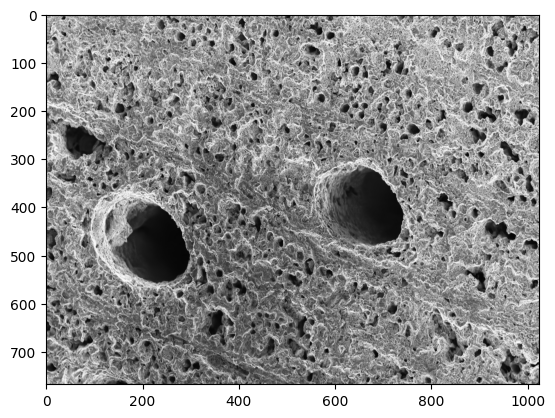

In [20]:
img_L_pil = pil2unit('test_images/test_1.png')
img_L_pil = uint2single(img_L_pil)  # Normalize to [0, 1]

# Plot the image
plt.imshow(single2uint(img_L_pil), cmap='gray')

In [23]:
img_L_pil_tensor = single2tensor(img_L_pil)
with torch.no_grad():
    img_L_pil_tensor.to(device)
    img_E_pil = test_onesplit(model, img_L_pil_tensor, refield=64, min_size=256, sf=1, modulo=1)
    img_E_pil = tensor2uint(img_E_pil)

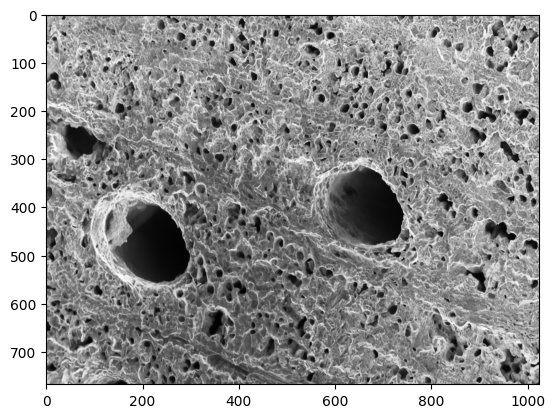

In [24]:
plt.imshow(img_E_pil, cmap='gray')

In [25]:
evaluate(pil2unit('test_images/test_1.png'), img_E_pil)

(21.630602773543718, np.float64(0.7026720092169282))

# TODO: create noisy collection